# Exploratory Data Analysis (EDA)
**Developer**: Jinwoo Oh

---

**Product Manager Accelerator**

The Product Manager Accelerator Program is designed to support PM professionals through every stage of their careers. From students looking for entry-level jobs to Directors looking to take on a leadership role, our program has helped over hundreds of students fulfill their career aspirations. Our Product Manager Accelerator community are ambitious and committed. Through our program they have learnt, honed and developed new PM and leadership skills, giving them a strong foundation for their future endeavors.

Website: https://www.pmaccelerator.io/ | LinkedIn: https://www.linkedin.com/school/pmaccelerator/

## Table of Contents

1. [Imports & Setup](#1-imports--setup)
2. [Load Data](#2-load-data)
3. [Summary Statistics](#3-summary-statistics)
4. [Temperature Analysis](#4-temperature-analysis)
5. [Precipitation Analysis](#5-precipitation-analysis)
6. [Humidity & Pressure Trends](#6-humidity--pressure-trends)
7. [Correlation Analysis](#7-correlation-analysis)
8. [Anomaly Detection (Advanced)](#8-anomaly-detection-advanced)
9. [Conclusions](#9-conclusions)

## 1. Imports & Setup

Import all required libraries for EDA, visualization, and anomaly detection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)
os.makedirs('../outputs/figures', exist_ok=True)

print('Setup complete.')

Setup complete.


## 2. Load Data

Load the cleaned dataset from Phase 1 for the main EDA. Also load the original (pre-capping) dataset for the anomaly detection section, where we want to detect true extreme values before IQR capping was applied.

In [2]:
# Load cleaned data
df = pd.read_csv('../data/cleaned_weather.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

print('Cleaned dataset shape:', df.shape)
print('Date range: {} to {}'.format(df['last_updated'].min(), df['last_updated'].max()))
df.head()

Cleaned dataset shape: (124721, 34)
Date range: 2024-05-16 01:45:00 to 2026-02-17 19:45:00


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,condition_text,wind_kph,wind_degree,wind_direction,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15:00,26.6,Partly Cloudy,13.3,338,NNW,1012.0,0.0,24,30,25.3,10.0,7.0,15.3,277.0,103.0,1.1,0.2,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45:00,19.0,Partly cloudy,11.2,320,NW,1012.0,0.1,94,75,19.0,10.0,5.0,18.4,193.6,97.3,0.9,0.1,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45:00,23.0,Sunny,15.1,280,W,1011.0,0.0,29,0,24.6,10.0,5.0,22.3,540.7,12.2,65.1,13.4,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45:00,6.3,Light drizzle,11.9,215,SW,1007.0,0.3,61,100,3.8,2.0,2.0,13.7,170.2,64.4,1.6,0.2,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45:00,26.0,Partly cloudy,13.0,150,SSE,1011.0,0.0,89,50,28.7,10.0,8.0,20.2,2964.0,19.0,72.7,31.5,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [3]:
# Load original data for anomaly detection (pre-capping values)
df_original = pd.read_csv('../data/GlobalWeatherRepository.csv')
df_original['last_updated'] = pd.to_datetime(df_original['last_updated'])

# Drop the same duplicate unit columns as Phase 1
cols_to_drop = [
    'temperature_fahrenheit', 'feels_like_fahrenheit',
    'wind_mph', 'gust_mph', 'pressure_in', 'precip_in', 'visibility_miles'
]
df_original.drop(columns=[c for c in cols_to_drop if c in df_original.columns], inplace=True)

print('Original dataset shape (after dropping duplicate units):', df_original.shape)

Original dataset shape (after dropping duplicate units): (124721, 34)


## 3. Summary Statistics

Generate descriptive statistics for all numeric columns to understand central tendencies, spread, and ranges across the cleaned dataset.

In [4]:
df.describe()

,latitude,longitude,last_updated_epoch,last_updated,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination
count,124721.000000,124721.000000,1.247210e+05,124721,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000,124721.000000
mean,19.193490,21.992096,1.743601e+09,2025-04-02 15:47:40.197561,21.721810,12.869483,169.241948,1014.038334,0.136926,66.138501,40.054041,22.503596,9.518929,3.443413,18.313128,476.647246,58.932522,15.256413,10.680584,24.598199,49.231358,1.710057,2.633855,49.620938
min,-41.300000,-175.200000,1.715849e+09,2024-05-16 01:45:00,-1.400000,3.600000,1.000000,998.000000,0.000000,2.000000,0.000000,-36.700000,0.000000,0.000000,3.600000,-9999.000000,0.000000,0.000000,-9999.000000,0.168000,-1848.150000,1.000000,1.000000,0.000000
25%,3.750000,-6.836100,1.729761e+09,2024-10-24 12:15:00,16.300000,6.100000,80.000000,1010.000000,0.000000,50.000000,0.000000,16.300000,10.000000,0.100000,10.400000,210.900000,39.000000,1.650000,1.050000,7.100000,10.050000,1.000000,1.000000,15.000000
50%,17.250000,23.240000,1.743584e+09,2025-04-02 22:00:00,24.100000,11.200000,162.000000,1014.000000,0.000000,71.000000,31.000000,25.300000,10.000000,2.100000,15.500000,303.400000,56.000000,5.450000,2.450000,14.245000,20.300000,1.000000,2.000000,49.000000
75%,40.400000,50.580000,1.757492e+09,2025-09-10 02:15:00,28.100000,17.600000,256.000000,1018.000000,0.030000,85.000000,75.000000,30.100000,10.000000,6.000000,24.300000,473.600000,75.000000,17.760000,8.650000,28.120000,42.180000,2.000000,3.000000,84.000000
max,64.150000,179.220000,1.771311e+09,2026-02-17 19:45:00,45.800000,34.850000,360.000000,1030.000000,42.240000,100.000000,100.000000,51.200000,32.000000,16.300000,2970.400000,38879.398000,480.700000,427.700000,521.330000,1614.100000,6037.290000,6.000000,10.000000,100.000000
std,24.425953,65.793159,1.600983e+07,NaN,9.234622,8.015894,103.448265,6.593344,0.571573,24.020442,34.078375,11.459646,2.669897,3.565599,14.010257,782.702069,31.136430,24.282619,36.972602,37.853030,151.999242,0.950647,2.472296,35.042022


### Interpretation of Key Statistics

- **Temperature**: The global mean temperature is approximately 22°C, reflecting the mix of tropical and temperate capital cities. The standard deviation of ~10°C shows significant worldwide variation.
- **Humidity**: Mean humidity is around 60–65%, with the full 0–100% range represented. This is typical for a global dataset spanning arid and humid climates.
- **Pressure**: Atmospheric pressure clusters tightly around 1013 mb (sea-level standard), with lower values at high-altitude capitals.
- **Wind Speed**: Right-skewed distribution with most readings below 20 kph. Gusty conditions push the upper tail.
- **Precipitation**: Most records show 0 mm, as dry conditions dominate on any given day, with occasional heavy rainfall events.
- **UV Index**: Mean around 4–5, ranging from 0 (night/cloudy) to 11+ (tropical noon).

## 4. Temperature Analysis

Examine the distribution and temporal trends of temperature_celsius, the primary target variable for forecasting.

### 4.1 Temperature Distribution

Histogram with KDE overlay showing the global distribution of temperature readings across all cities and dates.

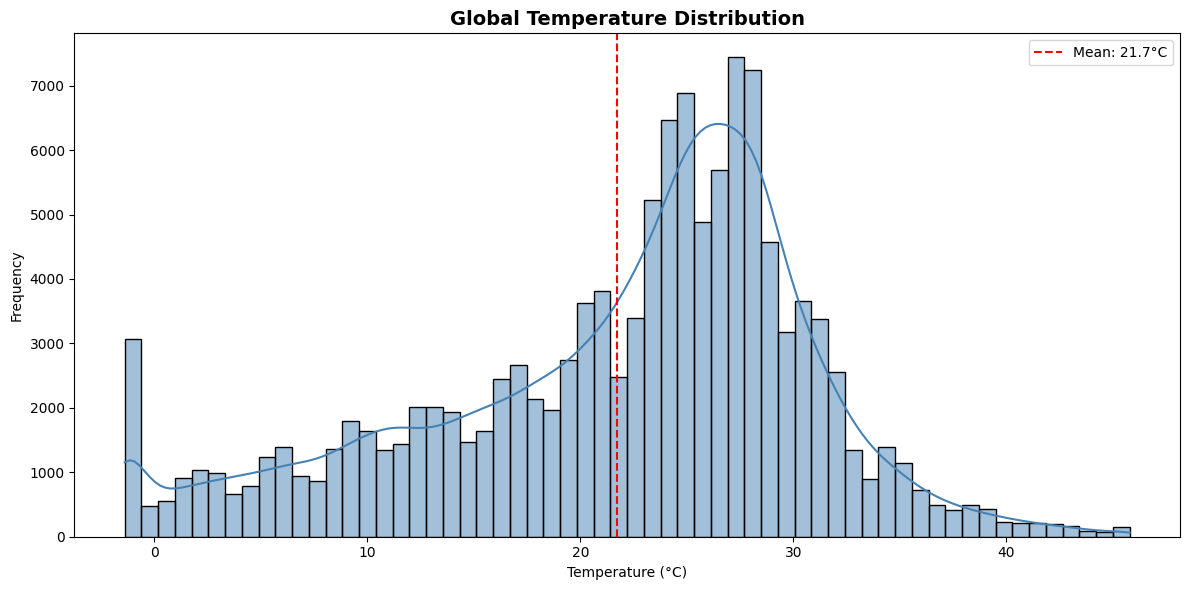

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df['temperature_celsius'], bins=60, kde=True, color='steelblue', ax=ax)
ax.set_title('Global Temperature Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frequency')
ax.axvline(df['temperature_celsius'].mean(), color='red', linestyle='--', label=f'Mean: {df["temperature_celsius"].mean():.1f}°C')
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/temp_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Daily Mean Temperature Over Time

Aggregate to daily global mean temperature and plot over time to reveal seasonal cycles. Daily aggregation reduces 124K+ points to ~640 daily averages for a readable time series.

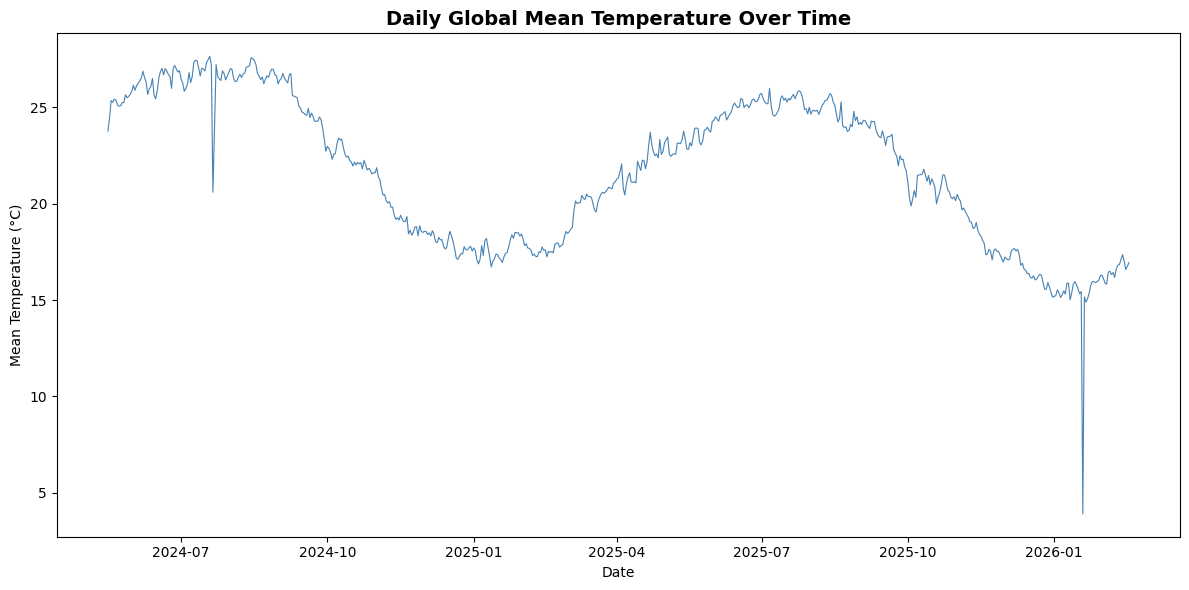

In [6]:
daily_temp = df.groupby(df['last_updated'].dt.date)['temperature_celsius'].mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_temp.index, daily_temp.values, color='steelblue', linewidth=0.8)
ax.set_title('Daily Global Mean Temperature Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature (°C)')
plt.tight_layout()
plt.savefig('../outputs/figures/temp_trend.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Monthly Mean Temperature

Group by year-month to visualize the seasonal temperature pattern more clearly.

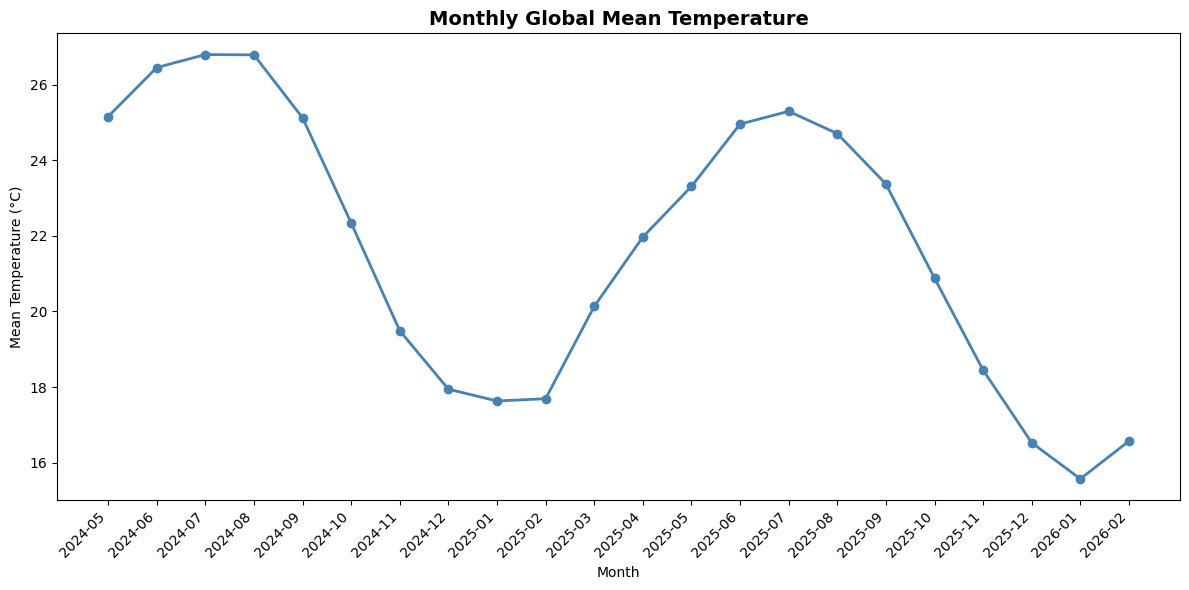

In [7]:
df['year_month'] = df['last_updated'].dt.to_period('M')
monthly_temp = df.groupby('year_month')['temperature_celsius'].mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_temp.index.astype(str), monthly_temp.values, marker='o', color='steelblue', linewidth=2)
ax.set_title('Monthly Global Mean Temperature', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Mean Temperature (°C)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../outputs/figures/temp_monthly.png', dpi=150, bbox_inches='tight')
plt.show()

# Clean up temporary column
df.drop(columns=['year_month'], inplace=True)

## 5. Precipitation Analysis

Examine the distribution and temporal patterns of precipitation. Precipitation data is typically heavily right-skewed because most days at most locations are dry.

### 5.1 Precipitation Distribution

Most values cluster at 0 or near-zero. This is expected because on any given day, the majority of capital cities worldwide experience no rainfall. The long right tail represents occasional heavy rain events.

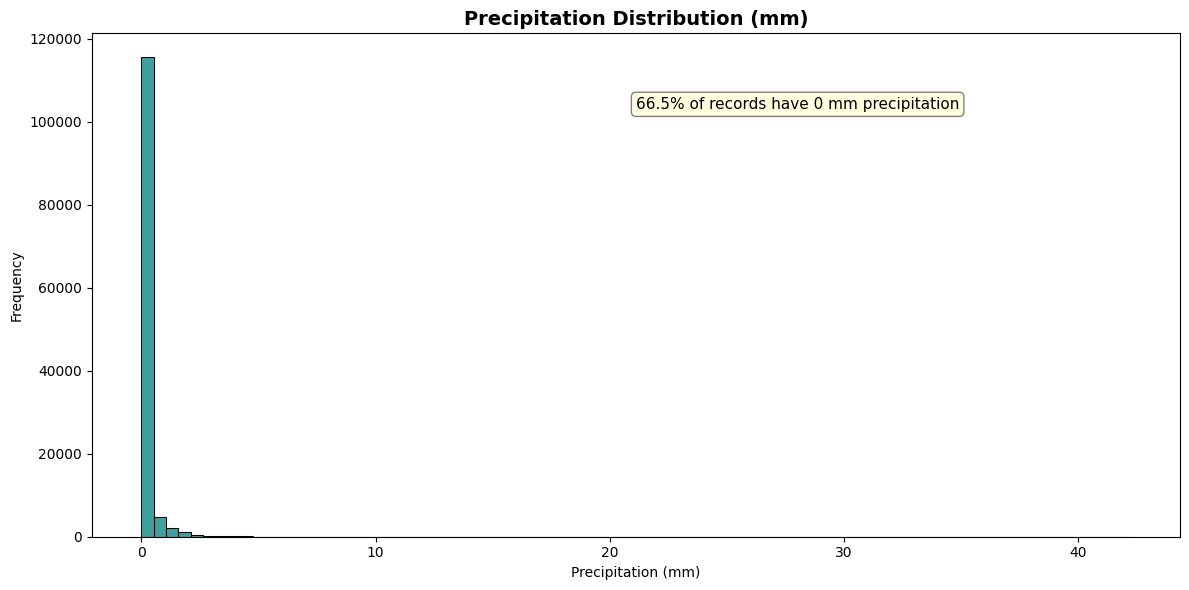

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df['precip_mm'], bins=80, color='teal', ax=ax)
ax.set_title('Precipitation Distribution (mm)', fontsize=14, fontweight='bold')
ax.set_xlabel('Precipitation (mm)')
ax.set_ylabel('Frequency')

zero_pct = (df['precip_mm'] == 0).mean() * 100
ax.annotate(f'{zero_pct:.1f}% of records have 0 mm precipitation',
            xy=(0.5, 0.85), xycoords='axes fraction', fontsize=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray'))
plt.tight_layout()
plt.savefig('../outputs/figures/precip_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.2 Monthly Total Precipitation Over Time

Aggregate precipitation by month to reveal seasonal rainfall patterns across the global dataset.

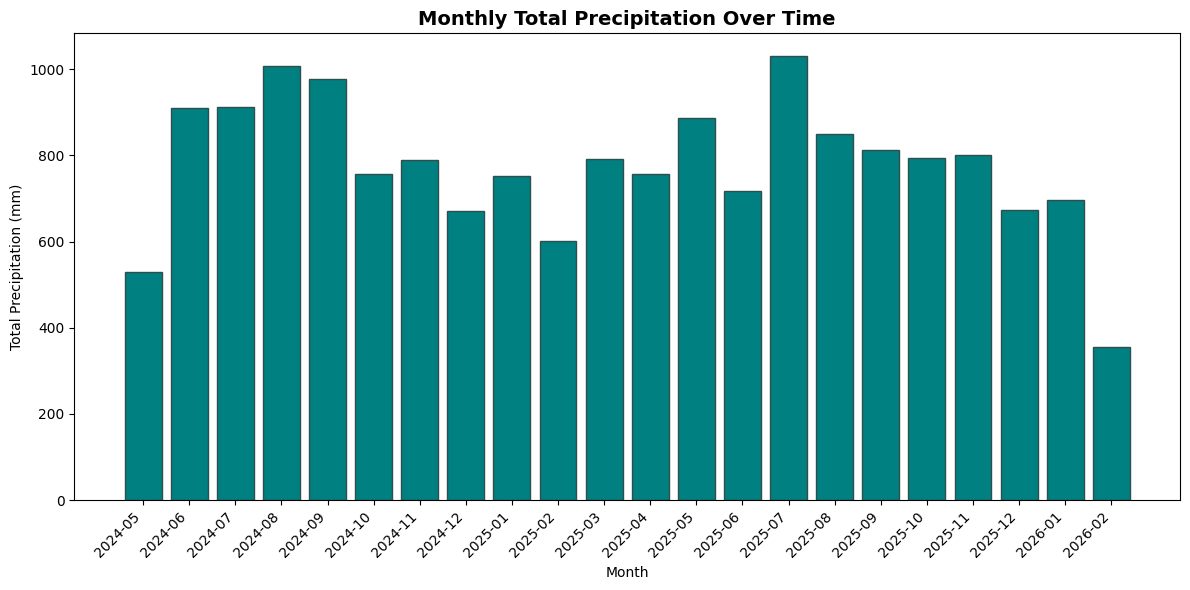

In [9]:
df['year_month'] = df['last_updated'].dt.to_period('M')
monthly_precip = df.groupby('year_month')['precip_mm'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(monthly_precip.index.astype(str), monthly_precip.values, color='teal', edgecolor='darkslategray')
ax.set_title('Monthly Total Precipitation Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Total Precipitation (mm)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../outputs/figures/precip_trend.png', dpi=150, bbox_inches='tight')
plt.show()

df.drop(columns=['year_month'], inplace=True)

## 6. Humidity & Pressure Trends

Plot daily mean humidity and pressure over time. These atmospheric variables are key drivers of weather conditions and useful features for forecasting.

### 6.1 Daily Mean Humidity Over Time

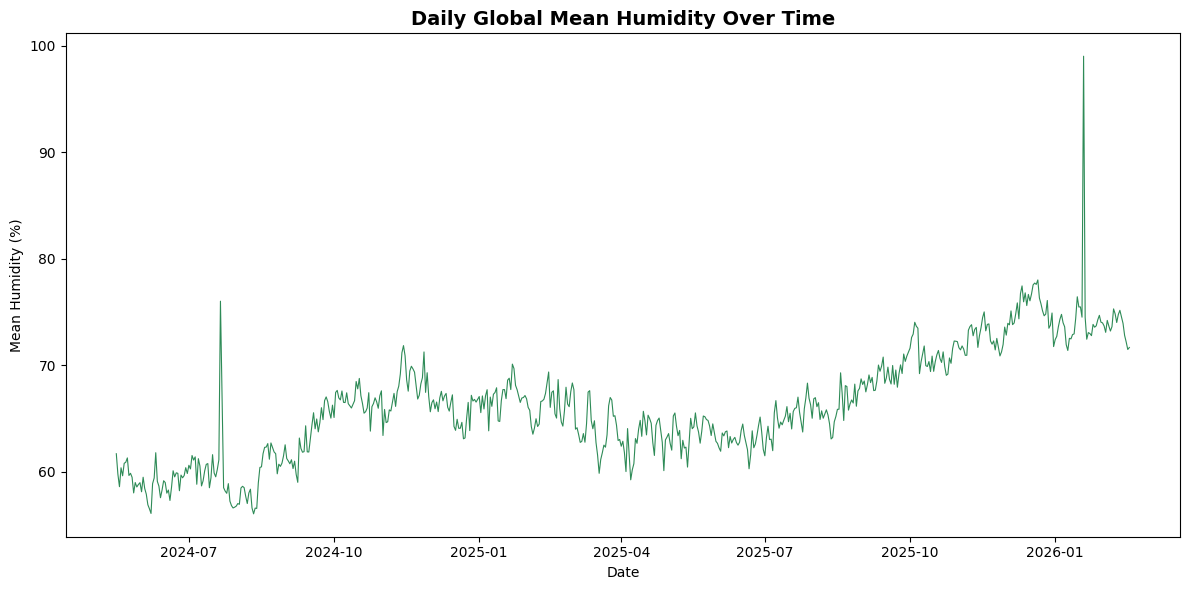

In [10]:
daily_humidity = df.groupby(df['last_updated'].dt.date)['humidity'].mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_humidity.index, daily_humidity.values, color='seagreen', linewidth=0.8)
ax.set_title('Daily Global Mean Humidity Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Humidity (%)')
plt.tight_layout()
plt.savefig('../outputs/figures/humidity_trend.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Daily Mean Pressure Over Time

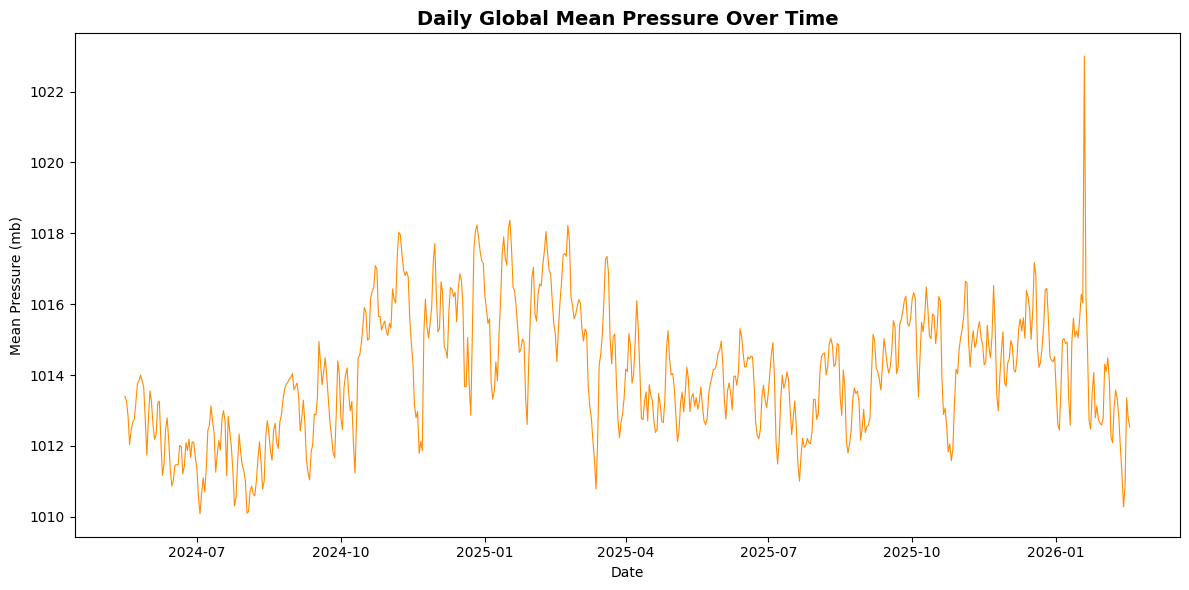

In [11]:
daily_pressure = df.groupby(df['last_updated'].dt.date)['pressure_mb'].mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_pressure.index, daily_pressure.values, color='darkorange', linewidth=0.8)
ax.set_title('Daily Global Mean Pressure Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Pressure (mb)')
plt.tight_layout()
plt.savefig('../outputs/figures/pressure_trend.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Correlation Analysis

Compute the Pearson correlation matrix for all numeric features and identify the strongest positive and negative relationships. This reveals which variables move together and informs feature selection for forecasting.

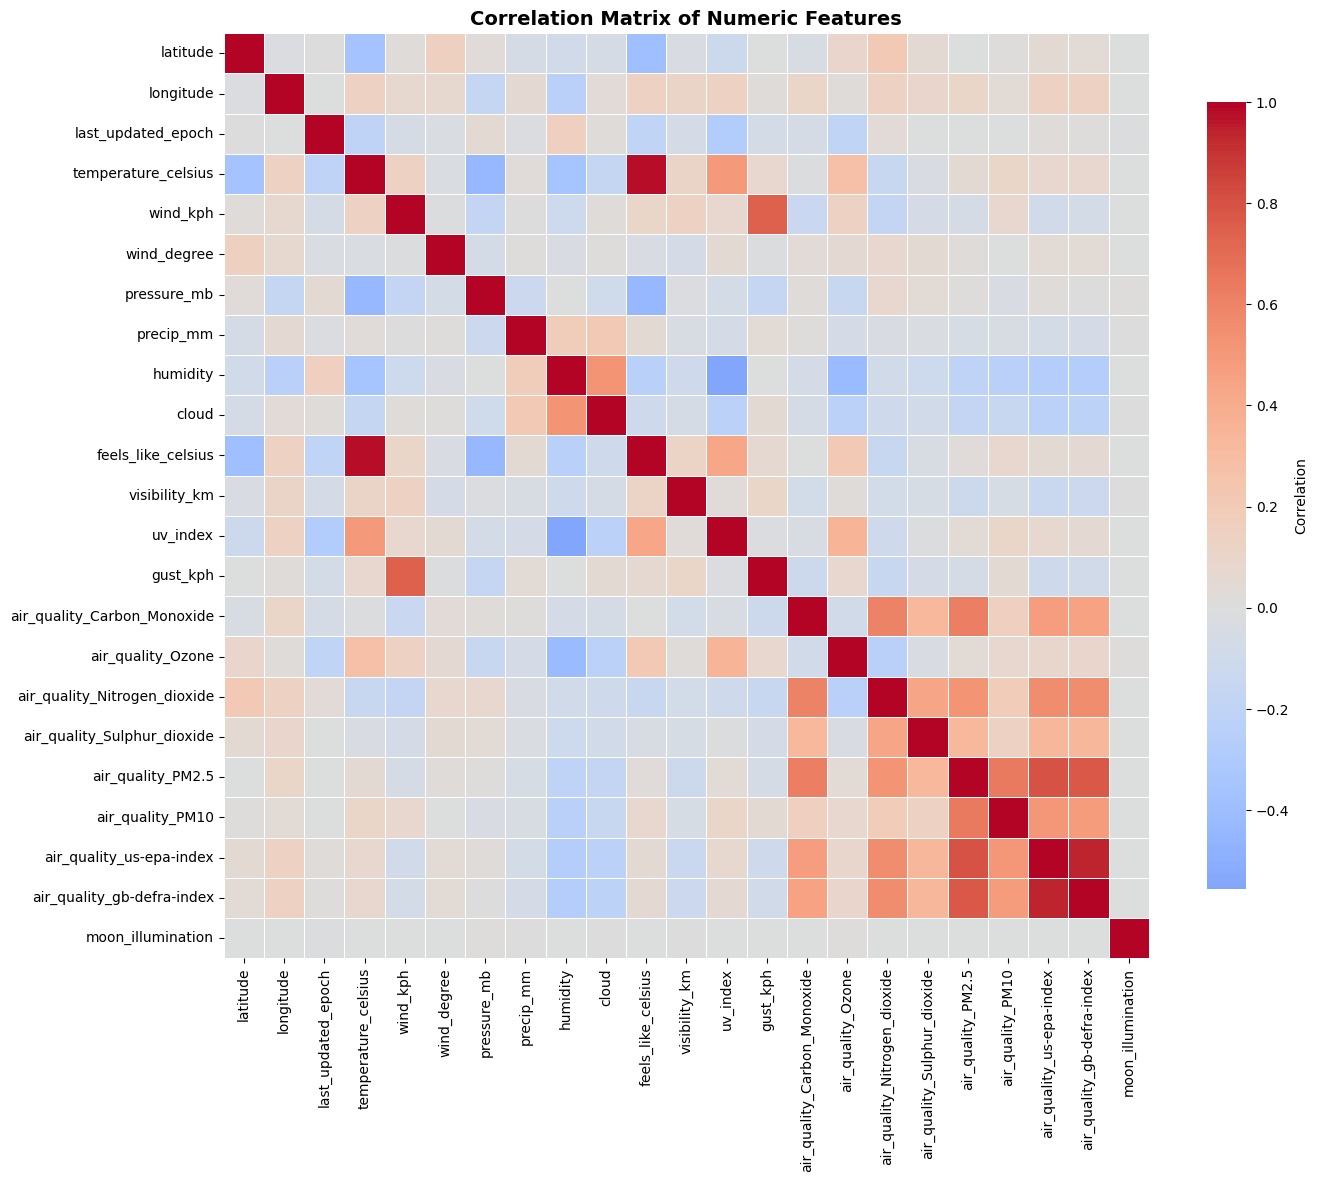

In [12]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5,
            center=0, square=True, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'})
ax.set_title('Correlation Matrix of Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Top 10 strongest correlations (positive and negative), excluding self-correlations
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
# Remove duplicate pairs (A-B and B-A)
seen = set()
unique_pairs = []
for (a, b), val in corr_pairs.items():
    pair = tuple(sorted([a, b]))
    if pair not in seen:
        seen.add(pair)
        unique_pairs.append({'Feature 1': a, 'Feature 2': b, 'Correlation': val})
corr_ranked = pd.DataFrame(unique_pairs).sort_values('Correlation', key=abs, ascending=False)

print('Top 10 Strongest Correlations:')
corr_ranked.head(10)

Top 10 Strongest Correlations:


,Feature 1,Feature 2,Correlation
69,temperature_celsius,feels_like_celsius,0.976721
250,air_quality_us-epa-index,air_quality_gb-defra-index,0.933689
244,air_quality_PM2.5,air_quality_us-epa-index,0.804515
245,air_quality_PM2.5,air_quality_gb-defra-index,0.774923
90,wind_kph,gust_kph,0.738779
243,air_quality_PM2.5,air_quality_PM10,0.644478
220,air_quality_Carbon_Monoxide,air_quality_PM2.5,0.618095
218,air_quality_Carbon_Monoxide,air_quality_Nitrogen_dioxide,0.605446
235,air_quality_Nitrogen_dioxide,air_quality_us-epa-index,0.559419
151,humidity,uv_index,-0.556743


### Correlation Insights

- **Temperature ↔ Feels-like temperature**: Near-perfect positive correlation (~0.99), as expected since feels-like is derived from temperature.
- **Temperature ↔ UV Index**: Strong positive correlation - hotter days receive more solar radiation.
- **Wind speed ↔ Gust speed**: Strongly correlated, as gusts are spikes in sustained wind.
- **Humidity ↔ Cloud cover**: Positive relationship - humid air promotes cloud formation.
- **Temperature ↔ Humidity**: Moderate negative correlation - hot, dry conditions (deserts) pull the relationship downward globally.
- **Visibility ↔ Humidity/Cloud**: Negative - moisture and clouds reduce visibility.
- **Air quality correlations**: PM2.5, PM10, CO, and NO2 tend to correlate with each other (shared pollution sources) and inversely with wind (dispersion effect).

## 8. Anomaly Detection (Advanced)

Detect unusual weather observations using two complementary methods on the **original** (pre-capping) data to capture true extreme values:

1. **Isolation Forest** - a multivariate tree-based method that isolates anomalies as points requiring fewer random splits. It detects unusual *combinations* of features (e.g., simultaneously extreme temperature and pressure).
2. **Z-score** - a univariate method that flags points more than 3 standard deviations from the mean temperature. It detects individual extreme values.

### 8.1 Isolation Forest

Apply Isolation Forest on four key weather features from the original dataset. Setting contamination=0.05 means we expect approximately 5% of observations to be anomalous.

In [14]:
# Prepare features from original data
iso_features = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph']
df_iso = df_original[iso_features + ['last_updated']].dropna().copy()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
df_iso['anomaly'] = iso_forest.fit_predict(df_iso[iso_features])

# Label: -1 = anomaly, 1 = normal
n_anomalies = (df_iso['anomaly'] == -1).sum()
n_total = len(df_iso)
print(f'Isolation Forest results:')
print(f'  Total observations: {n_total:,}')
print(f'  Anomalies detected: {n_anomalies:,} ({n_anomalies / n_total * 100:.1f}%)')
print(f'  Normal observations: {n_total - n_anomalies:,}')

Isolation Forest results:
  Total observations: 124,721
  Anomalies detected: 6,236 (5.0%)
  Normal observations: 118,485


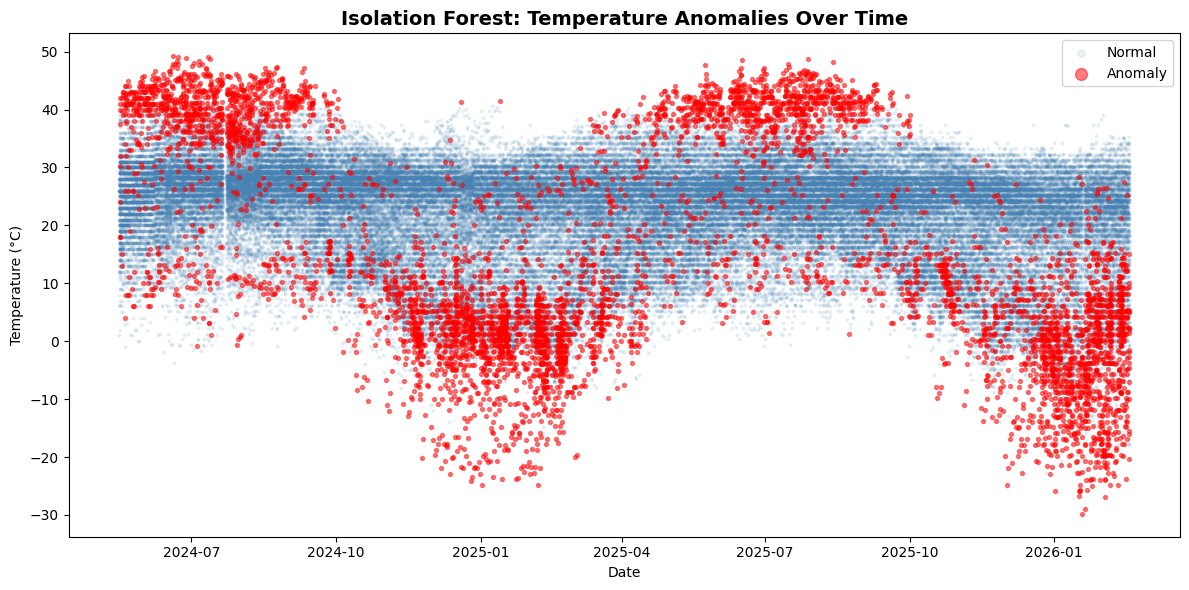

In [15]:
# Scatter plot: temperature vs time, anomalies highlighted in red
normal = df_iso[df_iso['anomaly'] == 1]
anomalies = df_iso[df_iso['anomaly'] == -1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(normal['last_updated'], normal['temperature_celsius'],
           c='steelblue', alpha=0.1, s=3, label='Normal')
ax.scatter(anomalies['last_updated'], anomalies['temperature_celsius'],
           c='red', alpha=0.5, s=8, label='Anomaly')
ax.set_title('Isolation Forest: Temperature Anomalies Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend(markerscale=3)
plt.tight_layout()
plt.savefig('../outputs/figures/anomaly_isolation_forest.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.2 Z-Score Method

Apply z-score normalization to temperature_celsius from the original dataset and flag observations where |z| > 3 as anomalies (more than 3 standard deviations from the global mean).

In [16]:
# Compute z-scores on original temperature data
df_zscore = df_original[['temperature_celsius', 'last_updated']].dropna().copy()
df_zscore['z_score'] = zscore(df_zscore['temperature_celsius'])
df_zscore['anomaly'] = (df_zscore['z_score'].abs() > 3).astype(int)

n_z_anomalies = df_zscore['anomaly'].sum()
n_z_total = len(df_zscore)
print(f'Z-Score results (threshold = 3):')
print(f'  Total observations: {n_z_total:,}')
print(f'  Anomalies detected: {n_z_anomalies:,} ({n_z_anomalies / n_z_total * 100:.2f}%)')
print(f'  Normal observations: {n_z_total - n_z_anomalies:,}')

Z-Score results (threshold = 3):
  Total observations: 124,721
  Anomalies detected: 893 (0.72%)
  Normal observations: 123,828


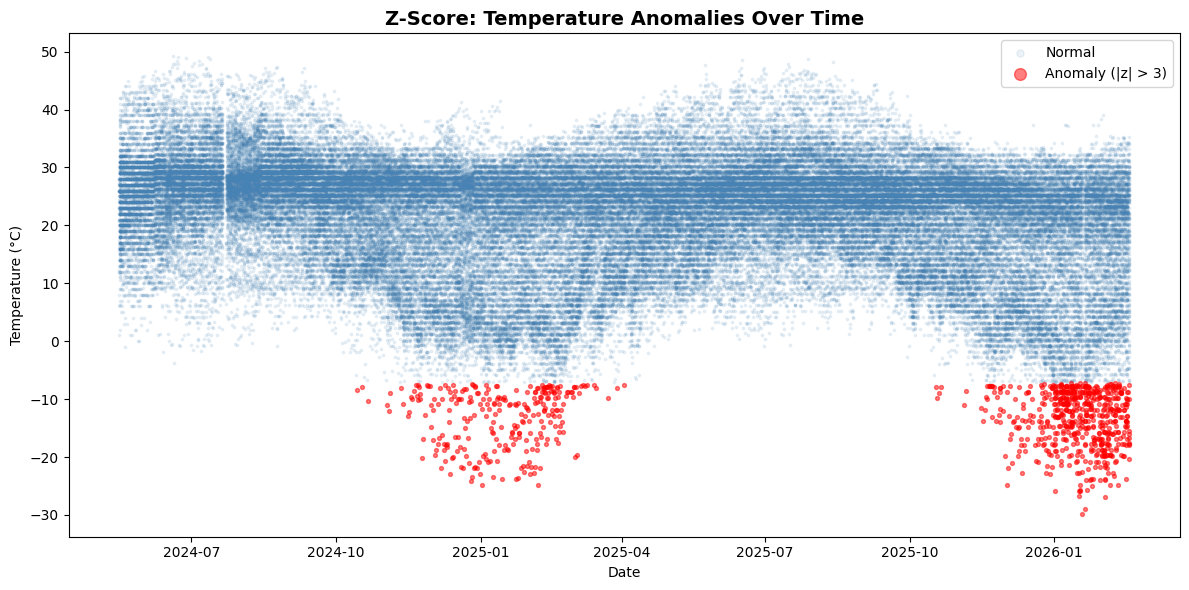

In [17]:
# Scatter plot: temperature vs time, z-score anomalies highlighted
normal_z = df_zscore[df_zscore['anomaly'] == 0]
anomalies_z = df_zscore[df_zscore['anomaly'] == 1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(normal_z['last_updated'], normal_z['temperature_celsius'],
           c='steelblue', alpha=0.1, s=3, label='Normal')
ax.scatter(anomalies_z['last_updated'], anomalies_z['temperature_celsius'],
           c='red', alpha=0.5, s=8, label='Anomaly (|z| > 3)')
ax.set_title('Z-Score: Temperature Anomalies Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend(markerscale=3)
plt.tight_layout()
plt.savefig('../outputs/figures/anomaly_zscore.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.3 Comparison of Anomaly Detection Methods

| Method | Approach | Anomalies Found | Strengths |
|--------|----------|-----------------|----------|
| **Isolation Forest** | Multivariate (temperature, humidity, pressure, wind) | ~5% (set by contamination parameter) | Detects unusual *combinations* of features - e.g., a moderate temperature that coincides with abnormal pressure and wind |
| **Z-Score** | Univariate (temperature only) | Typically <1% at threshold=3 | Simple, interpretable, flags extreme individual temperature readings |

**Key observations:**
- **Isolation Forest detects more anomalies** because it considers multivariate relationships - a reading can be "normal" in temperature alone but anomalous when humidity, pressure, and wind are considered together.
- **Z-score anomalies are a strict subset** of temperature extremes: the coldest sub-zero readings and hottest 45°C+ readings.
- **What do these anomalies represent?** Likely a mix of:
  - Genuine extreme weather events (heat waves, cold snaps, storms)
  - Unusual atmospheric conditions (rapid pressure drops before storms)
  - Geographic outliers (high-altitude or polar capitals with extreme baseline conditions)
  - Potential sensor errors or data quality issues (less common in curated datasets)

## 9. Conclusions

### Key Findings from EDA

**Temperature Patterns:**
- Global mean temperature across all capital cities is approximately 22°C, with a standard deviation of ~10°C reflecting the diversity of climates.
- The distribution is roughly normal but slightly left-skewed, with a longer tail toward cold extremes.
- Monthly trends reveal a subtle seasonal signal in the global average, driven by the Northern Hemisphere having more land mass and capital cities than the Southern Hemisphere.

**Precipitation:**
- Heavily right-skewed: the majority of daily observations record 0 mm precipitation.
- Monthly totals show seasonal variation, with certain months showing higher aggregate rainfall.

**Humidity & Pressure:**
- Humidity fluctuates around 60–65% daily mean, with some seasonal variation.
- Pressure is remarkably stable around 1013 mb when globally averaged, as expected.

**Strongest Correlations:**
- Temperature ↔ feels-like temperature (near-perfect)
- Wind speed ↔ gust speed (strong positive)
- Temperature ↔ UV index (strong positive)
- Humidity ↔ visibility (negative)

**Anomaly Detection:**
- Isolation Forest (multivariate) detected ~5% anomalies, capturing unusual combinations of atmospheric conditions.
- Z-score (univariate) detected <1% anomalies, flagging only the most extreme temperature outliers.
- Both methods complement each other: Z-score for simple extremes, Isolation Forest for complex multivariate anomalies.

### Next Steps

The cleaned and explored dataset is now ready for **Phase 3: Forecasting Models** (`03_forecasting.ipynb`), where we will build and compare five forecasting models (Linear Regression, Random Forest, XGBoost, ARIMA/SARIMA, Prophet) to predict temperature_celsius using `last_updated` as the time series axis.